# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:  

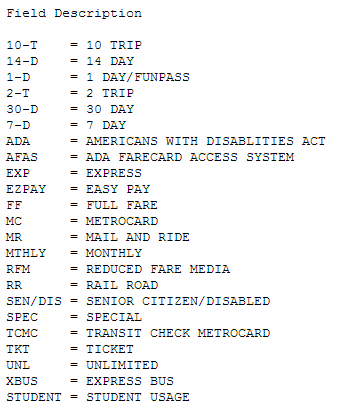

In [1]:
from IPython.display import Image
# downloading image 
!curl https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW11_fb55/Ridetypes.png > Ridetypes.png
Image(filename = "Ridetypes.png")

In [ ]:
__author__ = 'Solution by Linda Jaber, CUSP NYU 2018, Principles of Urban Informatics'
from __future__ import print_function, division

import matplotlib.pylab as plt
import matplotlib.dates as mdates

import numpy as np
import pandas as pd

import statsmodels.api as sm

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.cross_validation import train_test_split
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
#plt.rcParams['font.size'] = 20

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
    


# 1. Acquiring in data

In [3]:
# downloading data
!curl https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW11_fb55/MTA_Fare.npy > MTA_Fare.npy

# loading data
mta = np.load('MTA_Fare.npy')

In [4]:
print ("MTA array shape:", mta.shape)

MTA array shape: (600, 23, 194)


In [5]:
# creating a date range
date = pd.date_range(start='05/19/2010', periods=194, freq='W')

In [6]:
len(date)

194

In [7]:
date

DatetimeIndex(['2010-05-23', '2010-05-30', '2010-06-06', '2010-06-13',
               '2010-06-20', '2010-06-27', '2010-07-04', '2010-07-11',
               '2010-07-18', '2010-07-25',
               ...
               '2013-12-01', '2013-12-08', '2013-12-15', '2013-12-22',
               '2013-12-29', '2014-01-05', '2014-01-12', '2014-01-19',
               '2014-01-26', '2014-02-02'],
              dtype='datetime64[ns]', length=194, freq='W-SUN')

In [8]:
# change value to floats to be able to change (-1) values to nans
mta = mta.astype(float)

# assign -1 values to nan
mta[mta == -1] = np.nan

(733915.0, 735266.0)

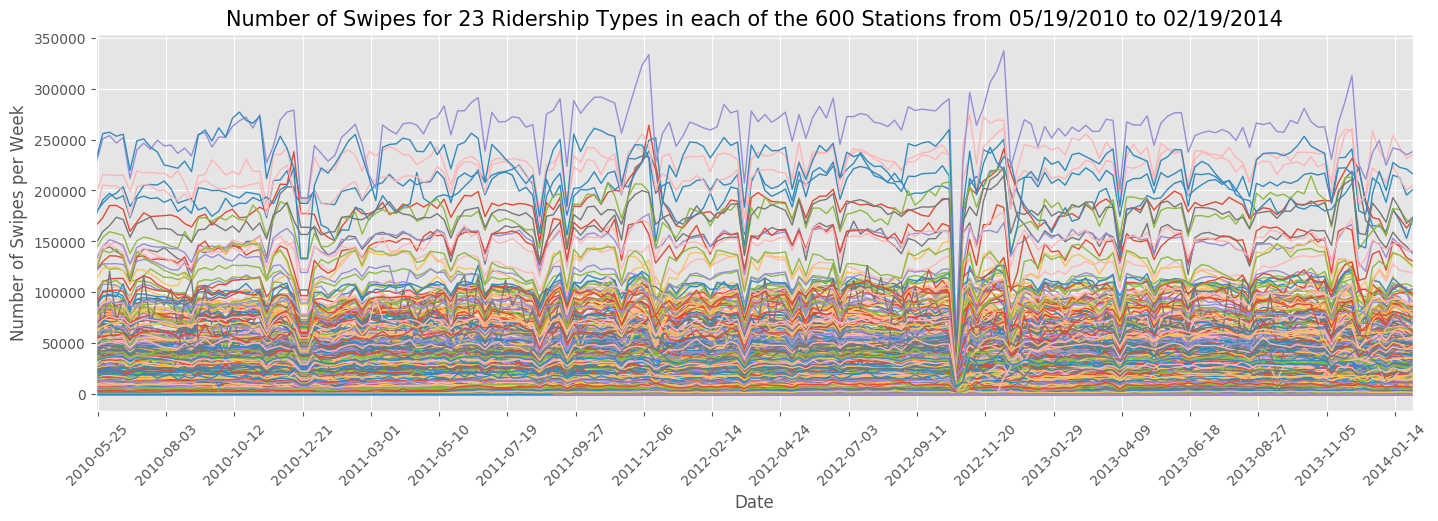

In [9]:
# choosing a plotting style fivethirtyeight or ggplot
plt.style.use('ggplot')

# plot the data in natural space
fig, ax = plt.subplots(figsize=(17,5), dpi=100)

for i in range(len(mta)):
    for ii in range(len(mta[i])):
        ax.plot(date, mta[i][ii], linewidth=1)
        
plt.xticks(rotation=45)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Swipes per Week', fontsize=12)
plt.title('Number of Swipes for 23 Ridership Types in each of the 600 Stations from 05/19/2010 to 02/19/2014', fontsize=15)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.xlim(date[0],date[-1])

#### Figure 1: time series for all ride types and all stations in natural space

(733915.0, 735266.0)

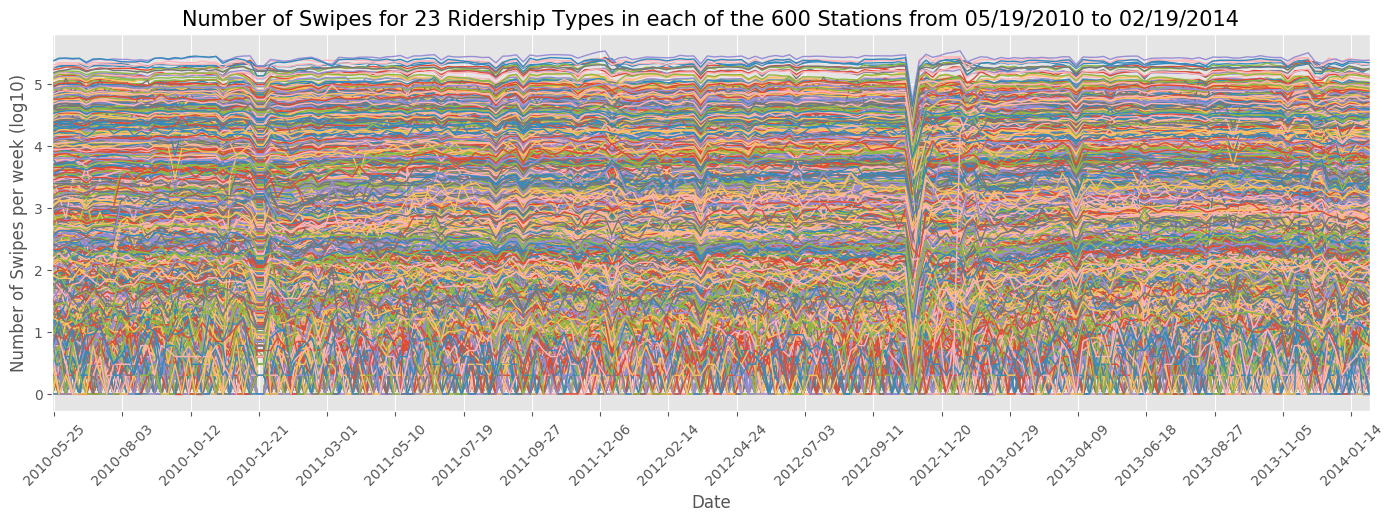

In [10]:
# then plot the  data in log space
fig, ax = plt.subplots(figsize=(17,5), dpi=100)

for i in range(len(mta)):
    for ii in range(len(mta[i])):
        ax.plot(date, np.log10(mta[i][ii]), linewidth=1)
        
plt.xticks(rotation=45)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Swipes per week (log10)', fontsize=12)
plt.title('Number of Swipes for 23 Ridership Types in each of the 600 Stations from 05/19/2010 to 02/19/2014', fontsize=15)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.xlim(date[0],date[-1])



#### Figure 2: time series for all ride types and all stations in semi-log space

# 2. Event detection 

** There is a very significant drop (>3-sigma) in all time series**

#### Summing on axis 1 (to collapse ridership types) and then on axis zero (to collapse stations) 

In [11]:
mta_ = np.nansum(mta, axis=1)
print ("MTA array shape summed over all ride types:", mta_.shape)

MTA array shape summed over all ride types: (600, 194)


In [12]:
mta_f = np.nansum(mta_, axis=0)
print ("mta_ array shape summed over all stations:", mta_f.shape)

mta_ array shape summed over all stations: (194,)


#### Calculating the thresholds of 3 sigmas away from the mean

In [13]:
print ("Mean number of swipes:  {:.2f}".format(np.nanmean(mta_f)))
print ("Standard deviation of number of swipes by week:  {:.2f}".format(np.nanstd(mta_f)))
thresholds = [np.nanmean(mta_f) + 3 * np.nanstd(mta_f), 
              np.nanmean(mta_f) - 3 * np.nanstd(mta_f)]
print ("3-sigma thresholds:  ({:.2f}, {:.2f})".format(*thresholds))

Mean number of swipes:  29781349.87
Standard deviation of number of swipes by week:  2983960.42
3-sigma thresholds:  (38733231.14, 20829468.61)


#### plotting the collapsed data with 3-sigma below the mean

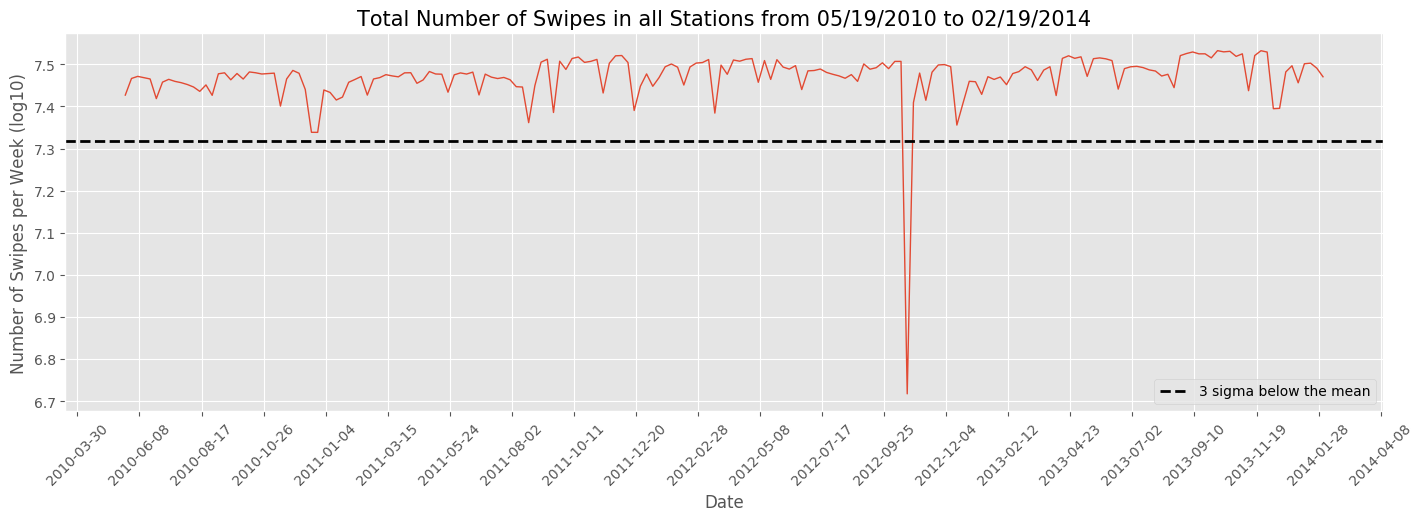

In [14]:
# plotting
fig, ax = plt.subplots(figsize=(17,5), dpi=100)

ax.plot(date, np.log10(mta_f), linewidth=1)
        
plt.xticks(rotation=45)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Swipes per Week (log10)', fontsize=12)
plt.title('Total Number of Swipes in all Stations from 05/19/2010 to 02/19/2014', fontsize=15)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))

ax.axhline(np.log10(thresholds[1]), linestyle='--', linewidth=2, color='k', label='3 sigma below the mean')

ax.legend(loc=4)
#plt.xlim(date[0],date[-1])

#### this is a plot of the collpsed data with a horizontal line specifying 3 -sigma below the mean

In [15]:
print (color.BOLD + 'Number of swipes per week that is less than 3 sigma below the mean = {}'.format(mta_f[mta_f < thresholds[1]]))

Number of swipes per week that is less than 3 sigma below the mean = [ 5218686.]


In [16]:
print(color.BOLD + 'Position of the week corresponding to the data point that is less than three signma below the mean = {}'.format(np.where(mta_f == 5218686)))

Position of the week corresponding to the data point that is less than three signma below the mean = (array([126]),)


In [17]:
print(color.BOLD + 'The date corresponding the week position = {}'.format(date[126]))

The date corresponding the week position = 2012-10-21 00:00:00


### I looked for what happened on that date and found the event below on this [Wikipedia link](https://patch.com/new-york/new-york-city/nyc-weekend-subway-service-changes-oct-20-21):
![alt text](images/event.png)

 # 3. Finding trends

In [18]:
# summing over axis zero to collapse the stations
mta_r = np.nansum(mta, axis=0)
mta_r.shape

(23, 194)

**create a "ride types" list based on the metadata I was given**

In [19]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp', 'ez',
            'ff', 'mc', 'mr', 'month', 'rfm', 'rr', 'sen', 'spec', 'tcmc', 't',
            'umlim', 'xbus', 'stud'])
print("number of ride types", len(ridetype))

number of ride types 23


In [20]:
# converting into a dataframe
mta_df = pd.DataFrame(mta_r.transpose(), columns=ridetype, index=date)
print('mta_df', mta_df.shape)
mta_df.head()

mta_df (194, 23)


10t       14d       1d        2t      30d         7d  \
2010-05-23  11494615.0  530524.0  47801.0  186551.0  46808.0  3697443.0   
2010-05-30  12526859.0  583533.0  51486.0  199229.0  64353.0  3981808.0   
2010-06-06  12766627.0  586194.0  51636.0  199668.0  56994.0  4033030.0   
2010-06-13  12653675.0  562602.0  52063.0  196389.0  37429.0  4032753.0   
2010-06-20  12809694.0  548858.0  51153.0  194883.0  35210.0  3925446.0   

                  ada     afas       exp        ez  ...      month       rfm  \
2010-05-23  8551937.0  10063.0  333197.0  512032.0  ...   123134.0  790110.0   
2010-05-30  9486394.0  11847.0  282755.0  578023.0  ...   151948.0  908068.0   
2010-06-06  9476538.0  12277.0  302028.0  615537.0  ...   151538.0  914124.0   
2010-06-13  9450081.0  11221.0  305513.0  606270.0  ...   147094.0  902549.0   
2010-06-20  9294002.0  10515.0  335780.0  563446.0  ...   137888.0  855573.0   

                 rr      sen   spec      tcmc        t   umlim   xbus  stud  
2010-05-23  59809.0  28221.0    0.0  124693.0  21060.0  6128.0  358.0   0.0  
2010-05-30  69209.0  32333.0    0.0  121713.0  21670.0  6120.0  474.0   0.0  
2010-06-06  69574.0  32618.0    0.0  122181.0  21433.0  6490.0  465.0   0.0  
2010-06-13  68099.0  32404.0    0.0  122051.0  21630.0  6590.0  484.0   0.0  
2010-06-20  66377.0  31933.0  176.0  119776.0  20297.0  6313.0  452.0   0.0  

[5 rows x 23 columns]

In [21]:
mta_df.dropna(inplace=True)

In [22]:
plt.gcf().axes

[]

[Text(146.625,0.5,'Number of swipes'),
 Text(422.505,0.5,'Number of swipes'),
 Text(719.886,0.5,'Number of swipes'),
 Text(1004.64,0.5,'Number of swipes'),
 Text(137.625,0.5,'Number of swipes'),
 Text(416.255,0.5,'Number of swipes'),
 Text(735.386,0.5,'Number of swipes'),
 Text(1010.77,0.5,'Number of swipes'),
 Text(131.375,0.5,'Number of swipes'),
 Text(422.505,0.5,'Number of swipes'),
 Text(719.886,0.5,'Number of swipes'),
 Text(1004.64,0.5,'Number of swipes'),
 Text(131.25,0.5,'Number of swipes'),
 Text(422.255,0.5,'Number of swipes'),
 Text(713.636,0.5,'Number of swipes'),
 Text(1004.64,0.5,'Number of swipes'),
 Text(131.375,0.5,'Number of swipes'),
 Text(428.755,0.5,'Number of swipes'),
 Text(713.511,0.5,'Number of swipes'),
 Text(1010.89,0.5,'Number of swipes'),
 Text(143.875,0.5,'Number of swipes'),
 Text(434.755,0.5,'Number of swipes'),
 Text(707.261,0.5,'Number of swipes'),
 Text(0,0.5,'Number of swipes')]

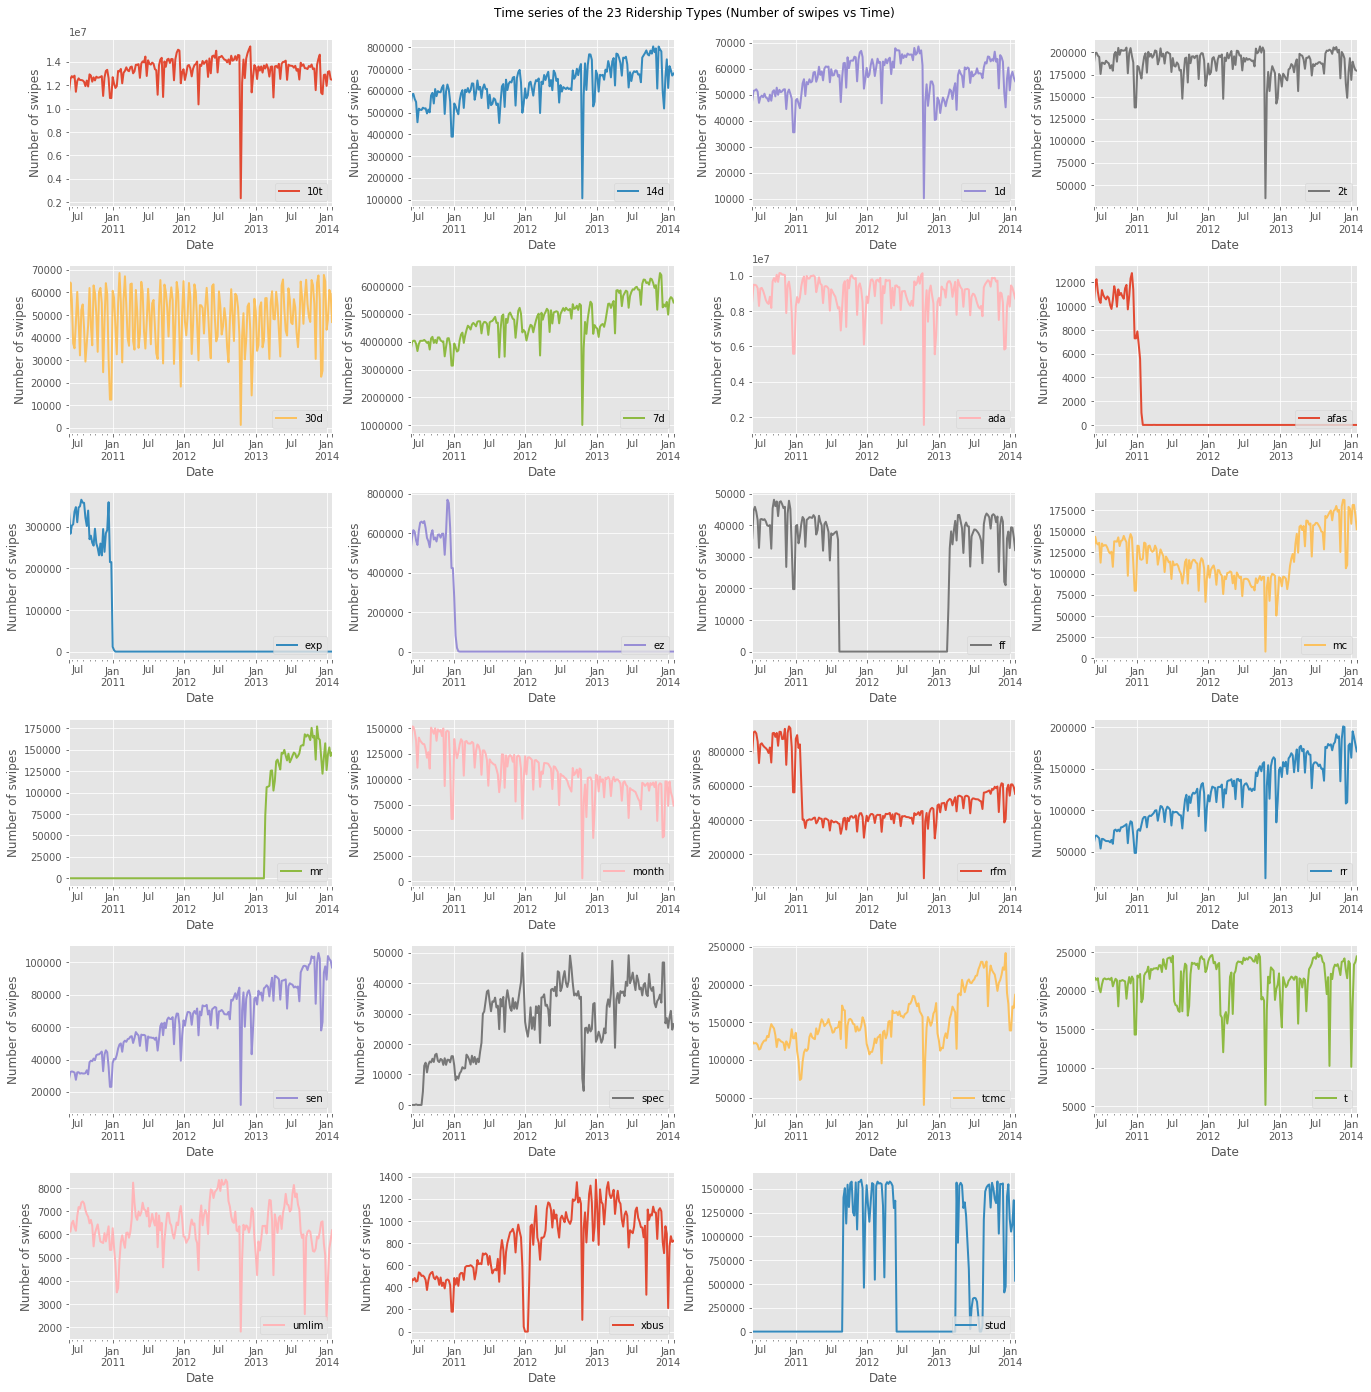

In [23]:
# plotting
ax = mta_df.plot(subplots=True, logy=False, sharex=False, sharey=False, layout=(-1,4), linewidth=2, #colormap='viridis', 
                 title='Time series of the 23 Ridership Types (Number of swipes vs Time)', figsize=(20,20))

tight_layout(pad=5, h_pad=2, w_pad=2)
[ax.legend(loc=4) for ax in plt.gcf().axes]
[ax.set_xlabel('Date') for ax in plt.gcf().axes]
[ax.set_ylabel('Number of swipes') for ax in plt.gcf().axes]


#for i in ax[0]:
 #   i[0].set_xlabel(date)
  #  i[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
   # i[0].xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))


#### Decomposing the time series

In [24]:
# initialize a dictionary
my_dict = {}

# Extrat the names of the time series / we can also use the ridetype numpy array created previously
ts_names = mta_df.columns

print(ts_names)

Index(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp', 'ez', 'ff',
       'mc', 'mr', 'month', 'rfm', 'rr', 'sen', 'spec', 'tcmc', 't', 'umlim',
       'xbus', 'stud'],
      dtype='object')


In [25]:
# run time series decomposition
for ts in ts_names:
    ts_decomposition = sm.tsa.seasonal_decompose(mta_df[ts])
    my_dict[ts] = ts_decomposition

#### extracting decomposition componenets of the time series

In [26]:
# initialize a new dictionary
my_dict_trend = {}

# Extract the trend component
for ts in ts_names:
    my_dict_trend[ts] = my_dict[ts].trend

# convert to a DataFrame
trend_df = pd.DataFrame.from_dict(my_dict_trend)
    
trend_df.head()

10t  14d  1d  2t  30d  7d  ada  afas  exp  ez  ...   mr  rfm  rr  \
2010-05-23  NaN  NaN NaN NaN  NaN NaN  NaN   NaN  NaN NaN  ...  NaN  NaN NaN   
2010-05-30  NaN  NaN NaN NaN  NaN NaN  NaN   NaN  NaN NaN  ...  NaN  NaN NaN   
2010-06-06  NaN  NaN NaN NaN  NaN NaN  NaN   NaN  NaN NaN  ...  NaN  NaN NaN   
2010-06-13  NaN  NaN NaN NaN  NaN NaN  NaN   NaN  NaN NaN  ...  NaN  NaN NaN   
2010-06-20  NaN  NaN NaN NaN  NaN NaN  NaN   NaN  NaN NaN  ...  NaN  NaN NaN   

            sen  spec  stud   t  tcmc  umlim  xbus  
2010-05-23  NaN   NaN   NaN NaN   NaN    NaN   NaN  
2010-05-30  NaN   NaN   NaN NaN   NaN    NaN   NaN  
2010-06-06  NaN   NaN   NaN NaN   NaN    NaN   NaN  
2010-06-13  NaN   NaN   NaN NaN   NaN    NaN   NaN  
2010-06-20  NaN   NaN   NaN NaN   NaN    NaN   NaN  

[5 rows x 23 columns]

#### plotting the trend component of each time series

[Text(146.625,0.5,'Number of swipes'),
 Text(422.255,0.5,'Number of swipes'),
 Text(719.761,0.5,'Number of swipes'),
 Text(1004.64,0.5,'Number of swipes'),
 Text(137.5,0.5,'Number of swipes'),
 Text(416.005,0.5,'Number of swipes'),
 Text(707.261,0.5,'Number of swipes'),
 Text(1017.27,0.5,'Number of swipes'),
 Text(131.25,0.5,'Number of swipes'),
 Text(422.505,0.5,'Number of swipes'),
 Text(719.886,0.5,'Number of swipes'),
 Text(1004.64,0.5,'Number of swipes'),
 Text(131.25,0.5,'Number of swipes'),
 Text(422.255,0.5,'Number of swipes'),
 Text(713.511,0.5,'Number of swipes'),
 Text(1004.64,0.5,'Number of swipes'),
 Text(137.625,0.5,'Number of swipes'),
 Text(428.63,0.5,'Number of swipes'),
 Text(707.386,0.5,'Number of swipes'),
 Text(1010.77,0.5,'Number of swipes'),
 Text(131.25,0.5,'Number of swipes'),
 Text(434.88,0.5,'Number of swipes'),
 Text(726.011,0.5,'Number of swipes'),
 Text(0,0.5,'Number of swipes')]

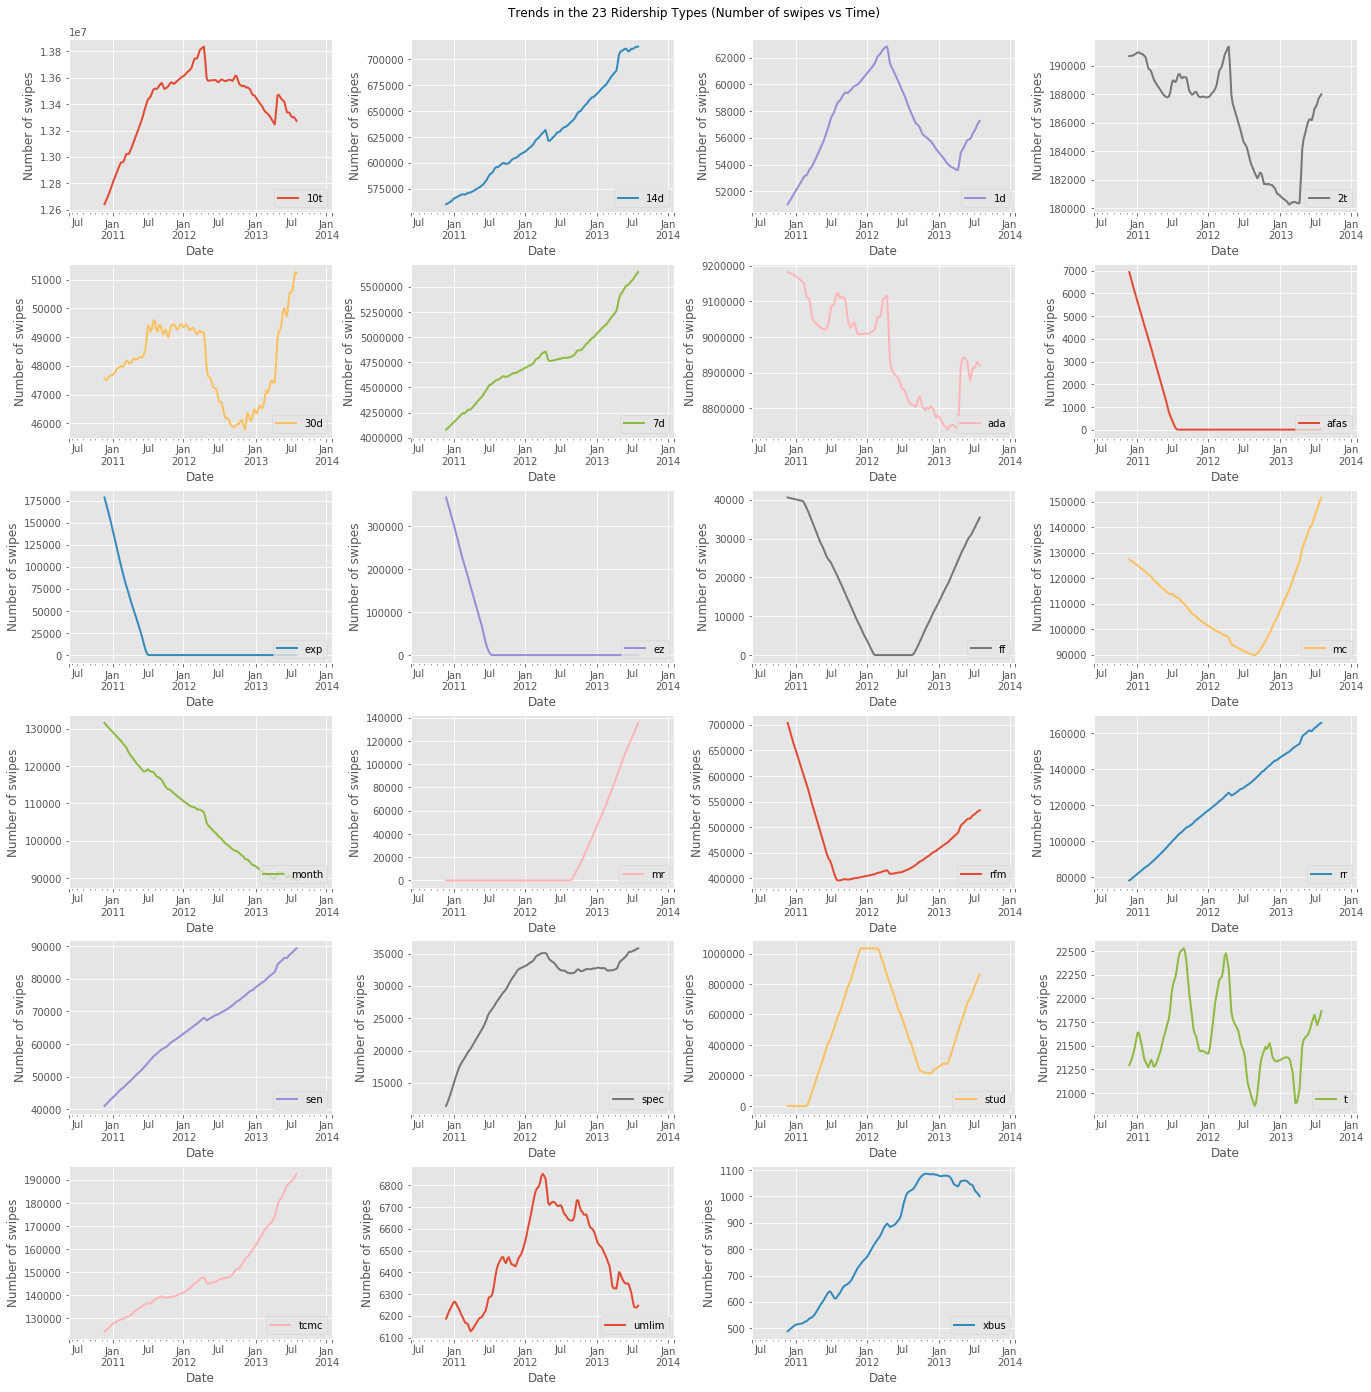

In [27]:
ax = trend_df.plot(subplots=True, logy=False, sharex=False, sharey=False, layout=(-1,4), linewidth=2, #colormap='viridis', 
                 title='Trends in the 23 Ridership Types (Number of swipes vs Time)', figsize=(20,20))

tight_layout(pad=5, h_pad=2, w_pad=2)
[ax.legend(loc=4) for ax in plt.gcf().axes]
[ax.set_xlabel('Date') for ax in plt.gcf().axes]
[ax.set_ylabel('Number of swipes') for ax in plt.gcf().axes]

#### From the trend plots above we can observe the following ridership types having a smooth trend:
1- 14d  
2- 7d  
3- month  
4- rr  
5- sen  
6 -tcmc

#### from this list above, type: 'month' is the only one showing a smooth negative trend.
#### will do further analysis to identify the steepest positive smooth trend.

In [28]:
description = trend_df.describe()
description

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


10t            14d            1d             2t           30d  \
count  1.420000e+02     142.000000    142.000000     142.000000    142.000000   
mean   1.340659e+07  627249.542050  57083.910956  186415.680458  48122.589856   
std    2.653845e+05   44822.800494   3093.009284    3458.638448   1362.766724   
min    1.264080e+07  560014.182692  51029.250000  180294.903846  45783.615385   
25%             NaN            NaN           NaN            NaN           NaN   
50%             NaN            NaN           NaN            NaN           NaN   
75%             NaN            NaN           NaN            NaN           NaN   
max    1.383567e+07  712195.605769  62831.701923  191317.884615  51260.653846   

                 7d           ada         afas            exp             ez  \
count  1.420000e+02  1.420000e+02   142.000000     142.000000     142.000000   
mean   4.772826e+06  8.961482e+06   834.398294   19429.939261   42424.197860   
std    3.827125e+05  1.347921e+05  1793.960218   44016.079032   93648.745288   
min    4.080290e+06  8.740362e+06     0.634615       2.240385       1.000000   
25%             NaN           NaN          NaN            NaN            NaN   
50%             NaN           NaN          NaN            NaN            NaN   
75%             NaN           NaN          NaN            NaN            NaN   
max    5.646895e+06  9.181770e+06  6937.048077  178510.490385  365939.605769   

          ...                  mr            rfm             rr           sen  \
count     ...          142.000000     142.000000     142.000000    142.000000   
mean      ...        22889.020043  467073.854618  122800.734493  65666.507245   
std       ...        39580.697911   75608.510141   25084.525658  13091.624072   
min       ...            1.625000  396075.000000   78082.836538  41030.144231   
25%       ...                 NaN            NaN            NaN           NaN   
50%       ...                 NaN            NaN            NaN           NaN   
75%       ...                 NaN            NaN            NaN           NaN   
max       ...       135546.971154  703738.240385  165827.490385  89286.038462   

               spec          stud             t           tcmc        umlim  \
count    142.000000  1.420000e+02    142.000000     142.000000   142.000000   
mean   29482.385496  5.067963e+05  21597.981514  148982.737202  6464.553697   
std     6227.784541  3.292841e+05    396.755563   17455.037436   204.084375   
min    11442.336538  0.000000e+00  20865.086538  124345.326923  6128.875000   
25%             NaN           NaN           NaN            NaN          NaN   
50%             NaN           NaN           NaN            NaN          NaN   
75%             NaN           NaN           NaN            NaN          NaN   
max    35802.125000  1.034176e+06  22527.615385  192644.682692  6852.625000   

              xbus  
count   142.000000  
mean    834.717700  
std     210.044318  
min     488.355769  
25%            NaN  
50%            NaN  
75%            NaN  
max    1085.865385  

[8 rows x 23 columns]

In [29]:
std = pd.DataFrame(description.loc['std'])
std.head()

std
10t  265384.501745
14d   44822.800494
1d     3093.009284
2t     3458.638448
30d    1362.766724

In [30]:
ratios = pd.DataFrame(description.loc['min'] / description.loc['max'], columns=(['ratio']))
ratios.head()

ratio
10t  0.913638
14d  0.786321
1d   0.812158
2t   0.942384
30d  0.893153

In [31]:
desc = std.merge(ratios, left_index=True, right_index=True)
desc.head()

std     ratio
10t  265384.501745  0.913638
14d   44822.800494  0.786321
1d     3093.009284  0.812158
2t     3458.638448  0.942384
30d    1362.766724  0.893153

In [32]:
desc.index

Index(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp', 'ez', 'ff',
       'mc', 'month', 'mr', 'rfm', 'rr', 'sen', 'spec', 'stud', 't', 'tcmc',
       'umlim', 'xbus'],
      dtype='object')

In [33]:
desc.drop(['10t', '1d', '2t', '30d', 'ada', 'afas', 'exp', 'ez', 'ff',
       'mc', 'month', 'mr', 'rfm', 'spec', 'stud', 't',
       'umlim', 'xbus'], inplace=True)
desc

std     ratio
14d    44822.800494  0.786321
7d    382712.472239  0.722572
rr     25084.525658  0.470868
sen    13091.624072  0.459536
tcmc   17455.037436  0.645465

In [34]:
desc[desc['ratio'] == desc['ratio'].min()]


std     ratio
sen  13091.624072  0.459536

In [35]:
desc[desc['std'] == desc['std'].min()]

std     ratio
sen  13091.624072  0.459536

#### It looks like type: 'sen' or 'senior/disabled' has the steepest smooth positive trend.

# 4. Classifing the *ride type* based on the time series characteristics using Random Forests

In [36]:
mta

array([[[  5.69610000e+04,   6.47030000e+04,   6.80020000e+04, ...,
           3.65270000e+04,   3.39290000e+04,   3.68240000e+04],
        [  1.73200000e+03,   2.08300000e+03,   2.10700000e+03, ...,
           1.26400000e+03,   1.17200000e+03,   1.23800000e+03],
        [  2.03000000e+02,   2.76000000e+02,   2.45000000e+02, ...,
           1.86000000e+02,   1.67000000e+02,   1.67000000e+02],
        ..., 
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [             nan,              nan,              nan, ...,
           1.12100000e+03,   1.37700000e+03,   7.12000000e+02]],

       [[  1.62100000e+04,   2.01790000e+04,   2.17690000e+04, ...,
                      nan,              nan,              nan],
        [  5.03000000e+02,   6.47000000e+02,   6.65000000e+0

In [37]:
mta.shape

(600, 23, 194)

In [38]:
mta.flatten()

array([ 56961.,  64703.,  68002., ...,     nan,     nan,     nan])

In [39]:
mta.flatten().shape

(2677200,)

In [40]:
# I give the first dimension that i want (600 * 23 which resembles all the statons and all the rider ship types) with -1 to let it figure the other dimension
mta.flatten().reshape(600 * 23, -1).shape

(13800, 194)

In [41]:
mta_all = mta.flatten().reshape(600 * 23, -1)
print(mta_all.shape)
mta_all

(13800, 194)


array([[ 56961.,  64703.,  68002., ...,  36527.,  33929.,  36824.],
       [  1732.,   2083.,   2107., ...,   1264.,   1172.,   1238.],
       [   203.,    276.,    245., ...,    186.,    167.,    167.],
       ..., 
       [    nan,     nan,     nan, ...,     nan,     nan,     nan],
       [    nan,     nan,     nan, ...,     nan,     nan,     nan],
       [    nan,     nan,     nan, ...,     nan,     nan,     nan]])

In [42]:
(np.tile((np.arange(0, 23)), 600)).shape

(13800,)

In [43]:
# there are 23 labels from 0 to 22
# initiate a range: l
l = np.arange(0, 23)
l

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22])

In [44]:
# use np.tile to repeat the range according to how many stations we have
label = np.tile(l, 600)
label.shape

(13800,)

In [45]:
# checking my labels array
label[:26]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22,  0,  1,  2])

In [46]:
# creatting a data frame with all the time series then will attach the label to each time series to be able to drop NaNs accordingly
df_all = pd.DataFrame(mta_all)
df_all.head()

0        1        2        3        4        5        6        7    \
0  56961.0  64703.0  68002.0  72628.0  75866.0  72433.0  71186.0  71498.0   
1   1732.0   2083.0   2107.0   2188.0   2314.0   1921.0   2072.0   1999.0   
2    203.0    276.0    245.0    280.0    265.0    241.0    278.0    236.0   
3    883.0    958.0    976.0    987.0   1012.0    927.0    898.0    902.0   
4    358.0    529.0    422.0    261.0    248.0    362.0    479.0    345.0   

       8        9     ...         184      185      186      187      188  \
0  73801.0  72517.0   ...     43608.0  44774.0  46955.0  39050.0  37384.0   
1   2031.0   1980.0   ...      1425.0   1085.0    965.0   1284.0   1407.0   
2    258.0    264.0   ...       217.0    189.0    150.0    194.0    183.0   
3    907.0    907.0   ...       576.0    460.0    388.0    517.0    593.0   
4    192.0    414.0   ...       290.0    109.0    124.0    349.0    357.0   

       189      190      191      192      193  
0  33864.0  38358.0  36527.0  33929.0  36824.0  
1   1085.0   1389.0   1264.0   1172.0   1238.0  
2    185.0    200.0    186.0    167.0    167.0  
3    498.0    538.0    545.0    516.0    489.0  
4    197.0    220.0    281.0    309.0    245.0  

[5 rows x 194 columns]

In [47]:
# create station labels
stations = np.repeat(np.arange(1,601), 23)

# creating a station feature
df_all['station'] = stations
df_all.head()

0        1        2        3        4        5        6        7  \
0  56961.0  64703.0  68002.0  72628.0  75866.0  72433.0  71186.0  71498.0   
1   1732.0   2083.0   2107.0   2188.0   2314.0   1921.0   2072.0   1999.0   
2    203.0    276.0    245.0    280.0    265.0    241.0    278.0    236.0   
3    883.0    958.0    976.0    987.0   1012.0    927.0    898.0    902.0   
4    358.0    529.0    422.0    261.0    248.0    362.0    479.0    345.0   

         8        9   ...         185      186      187      188      189  \
0  73801.0  72517.0   ...     44774.0  46955.0  39050.0  37384.0  33864.0   
1   2031.0   1980.0   ...      1085.0    965.0   1284.0   1407.0   1085.0   
2    258.0    264.0   ...       189.0    150.0    194.0    183.0    185.0   
3    907.0    907.0   ...       460.0    388.0    517.0    593.0    498.0   
4    192.0    414.0   ...       109.0    124.0    349.0    357.0    197.0   

       190      191      192      193  station  
0  38358.0  36527.0  33929.0  36824.0        1  
1   1389.0   1264.0   1172.0   1238.0        1  
2    200.0    186.0    167.0    167.0        1  
3    538.0    545.0    516.0    489.0        1  
4    220.0    281.0    309.0    245.0        1  

[5 rows x 195 columns]

In [48]:
# creating a label feature
df_all['ridership'] = label
df_all.head()

0        1        2        3        4        5        6        7  \
0  56961.0  64703.0  68002.0  72628.0  75866.0  72433.0  71186.0  71498.0   
1   1732.0   2083.0   2107.0   2188.0   2314.0   1921.0   2072.0   1999.0   
2    203.0    276.0    245.0    280.0    265.0    241.0    278.0    236.0   
3    883.0    958.0    976.0    987.0   1012.0    927.0    898.0    902.0   
4    358.0    529.0    422.0    261.0    248.0    362.0    479.0    345.0   

         8        9    ...          186      187      188      189      190  \
0  73801.0  72517.0    ...      46955.0  39050.0  37384.0  33864.0  38358.0   
1   2031.0   1980.0    ...        965.0   1284.0   1407.0   1085.0   1389.0   
2    258.0    264.0    ...        150.0    194.0    183.0    185.0    200.0   
3    907.0    907.0    ...        388.0    517.0    593.0    498.0    538.0   
4    192.0    414.0    ...        124.0    349.0    357.0    197.0    220.0   

       191      192      193  station  ridership  
0  36527.0  33929.0  36824.0        1          0  
1   1264.0   1172.0   1238.0        1          1  
2    186.0    167.0    167.0        1          2  
3    545.0    516.0    489.0        1          3  
4    281.0    309.0    245.0        1          4  

[5 rows x 196 columns]

In [49]:
# dropping NaNs
df_all.dropna(inplace=True)
print('df_all new shape after droping NaNs = {}'.format(df_all.shape))

df_all new shape after droping NaNs = (9174, 196)


df_all.to_csv('tem.csv')


In [50]:
df_all['mean_ridership'] = df_all.iloc[:, 0:194].mean(axis=1)
df_all['std_ridership'] = df_all.iloc[:, 0:194].std(axis=1)
df_all.head()

0       1       2       3       4       5       6       7       8  \
46  3292.0  3429.0  3629.0  2808.0  3614.0  2601.0  2848.0  2798.0  2888.0   
47   110.0    92.0   102.0    79.0    93.0    74.0    72.0    92.0    97.0   
48     7.0     6.0    13.0     7.0     5.0     7.0     7.0     6.0     3.0   
49    41.0    51.0    47.0    37.0    50.0    43.0    44.0    32.0    43.0   
50     0.0     0.0     0.0     0.0     1.0     1.0     0.0     0.0     0.0   

         9      ...           188     189     190     191     192     193  \
46  3591.0      ...        3599.0  3273.0  3418.0  3746.0  3406.0  3217.0   
47    95.0      ...         204.0   166.0   191.0   212.0   209.0   211.0   
48     4.0      ...          19.0    13.0    19.0    26.0    20.0    22.0   
49    57.0      ...          25.0    29.0    31.0    28.0    24.0    22.0   
50     2.0      ...           8.0     6.0     5.0     5.0     6.0     0.0   

    station  ridership  mean_ridership  std_ridership  
46        3          0     3548.917526     392.413105  
47        3          1      144.587629      43.713564  
48        3          2       17.938144       8.158170  
49        3          3       30.257732       9.835200  
50        3          4        2.896907       4.246265  

[5 rows x 198 columns]

In [51]:
temp_1 = pd.DataFrame((df_all.iloc[:, 0:194].groupby(df_all['station']).mean()).mean(axis=1)).reset_index()
temp_1.columns = ['station', 'mean_station']
temp_1.head()

station  mean_station
0        3    314.881443
1        4    793.871837
2        5    893.424086
3        6    980.435801
4        7    608.383083

In [52]:
temp_2 = pd.DataFrame((df_all.iloc[:, 0:194].groupby(df_all['station']).std()).std(axis=1)).reset_index()
temp_2.columns = ['station', 'std_station']
temp_2.head()

station  std_station
0        3    94.344810
1        4   220.603171
2        5   240.332874
3        6   271.673094
4        7   164.317831

In [53]:
df_all = df_all.merge(temp_1, on='station').merge(temp_2, on='station')
df_all.head()

0       1       2       3       4       5       6       7       8  \
0  3292.0  3429.0  3629.0  2808.0  3614.0  2601.0  2848.0  2798.0  2888.0   
1   110.0    92.0   102.0    79.0    93.0    74.0    72.0    92.0    97.0   
2     7.0     6.0    13.0     7.0     5.0     7.0     7.0     6.0     3.0   
3    41.0    51.0    47.0    37.0    50.0    43.0    44.0    32.0    43.0   
4     0.0     0.0     0.0     0.0     1.0     1.0     0.0     0.0     0.0   

        9     ...          190     191     192     193  station  ridership  \
0  3591.0     ...       3418.0  3746.0  3406.0  3217.0        3          0   
1    95.0     ...        191.0   212.0   209.0   211.0        3          1   
2     4.0     ...         19.0    26.0    20.0    22.0        3          2   
3    57.0     ...         31.0    28.0    24.0    22.0        3          3   
4     2.0     ...          5.0     5.0     6.0     0.0        3          4   

   mean_ridership  std_ridership  mean_station  std_station  
0     3548.917526     392.413105    314.881443     94.34481  
1      144.587629      43.713564    314.881443     94.34481  
2       17.938144       8.158170    314.881443     94.34481  
3       30.257732       9.835200    314.881443     94.34481  
4        2.896907       4.246265    314.881443     94.34481  

[5 rows x 200 columns]

In [54]:
df_all['f_1'] = df_all['mean_ridership'] / df_all['mean_station']
df_all['f_2'] = df_all['std_ridership'] / df_all['std_station']

Text(0,0.5,'standardized number of rides')

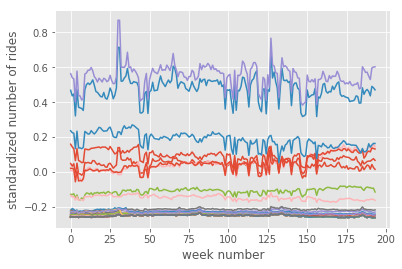

In [55]:
standardizedts = (df_all.iloc[:, :194] - df_all.iloc[:, :194].mean()) / df_all.iloc[:, :194].std()
for i in range(60):
    plt.plot(standardizedts.iloc[i,:])
plt.xlabel("week number")
plt.ylabel("standardized number of rides")

#### plot of 60 of the standerdized time series

In [56]:
y = standardizedts.iloc[i, :]
x = sm.add_constant(np.arange(194))

In [57]:
allfits = []

for i in range(len(standardizedts)):
    ols = sm.OLS(y, x).fit()
    allfits.append(ols)
[a.params[0] for a in allfits[:10]]

[-0.24844250158144007,
 -0.24844250158144007,
 -0.24844250158144007,
 -0.24844250158144007,
 -0.24844250158144007,
 -0.24844250158144007,
 -0.24844250158144007,
 -0.24844250158144007,
 -0.24844250158144007,
 -0.24844250158144007]

You can use the sklearn train_test_split() function to create your training and test dataset. 

In [58]:
df_all['f_3'] = np.array([a.params[0] for a in allfits])
df_all['f_4'] = np.array([a.params[1] for a in allfits])
df_all.head()

0       1       2       3       4       5       6       7       8  \
0  3292.0  3429.0  3629.0  2808.0  3614.0  2601.0  2848.0  2798.0  2888.0   
1   110.0    92.0   102.0    79.0    93.0    74.0    72.0    92.0    97.0   
2     7.0     6.0    13.0     7.0     5.0     7.0     7.0     6.0     3.0   
3    41.0    51.0    47.0    37.0    50.0    43.0    44.0    32.0    43.0   
4     0.0     0.0     0.0     0.0     1.0     1.0     0.0     0.0     0.0   

        9    ...     station  ridership  mean_ridership  std_ridership  \
0  3591.0    ...           3          0     3548.917526     392.413105   
1    95.0    ...           3          1      144.587629      43.713564   
2     4.0    ...           3          2       17.938144       8.158170   
3    57.0    ...           3          3       30.257732       9.835200   
4     2.0    ...           3          4        2.896907       4.246265   

   mean_station  std_station        f_1       f_2       f_3       f_4  
0    314.881443     94.34481  11.270647  4.159350 -0.248443 -0.000011  
1    314.881443     94.34481   0.459181  0.463338 -0.248443 -0.000011  
2    314.881443     94.34481   0.056968  0.086472 -0.248443 -0.000011  
3    314.881443     94.34481   0.096092  0.104247 -0.248443 -0.000011  
4    314.881443     94.34481   0.009200  0.045008 -0.248443 -0.000011  

[5 rows x 204 columns]

f1 = df_all['f_1'].values
f2 = df_all['f_2'].values
f3 = df_all['f_3'].values
f4 = df_all['f_4'].values.
label = df_all['ridership'].values.reshape(-1,1)

df_all.iloc[:, -4:]

In [59]:
X_train, X_test, y_train, y_test = train_test_split(df_all.iloc[:, -4:], df_all['ridership'], test_size=0.33, 
                                                    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    np.array([[a.params[0] for a in allfits], [a.params[1] for a in allfits], 
              np.mean(ts)/normedtsmean, np.std(ts)/normedtsstd]).T, 
    label, test_size=0.33, random_state=42, shuffle=True)

In [60]:
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape

((6146, 4), (3028, 4), (6146,), (3028,))

depending on the details of your data processing you may have infinities as well. You also will have to get read of them

(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

X_train[~np.isfinite(X_train)] = # ... make a choice about what to do with this datapoint. drop it or replace it with something

In [61]:
clf = rfc()
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

and use sklearn confusion_matrix to see the errors

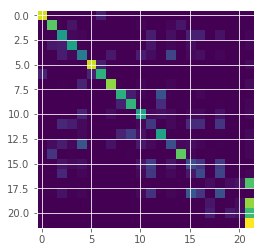

In [62]:
y_pred = clf.predict(X_test)
imshow(confusion_matrix(y_test, y_pred))

 and use classification_report to assess the model and clf.feature_importances_ to find the important features

In [63]:
print('feature importance: ', clf.feature_importances_)

feature importance:  [ 0.53204649  0.46795351  0.          0.        ]


#### we conclude from this that that the two most important features are the first 2 features

In [64]:
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.90      0.91      0.91       151
        14d       0.73      0.82      0.77       134
         1d       0.49      0.58      0.53       139
         2t       0.71      0.68      0.70       126
        30d       0.42      0.43      0.43       146
         7d       0.88      0.89      0.89       154
        ada       0.79      0.77      0.78       123
       afas       0.85      0.84      0.85       146
        exp       0.77      0.64      0.70       147
         ez       0.71      0.72      0.72       134
         ff       0.62      0.63      0.63       137
         mc       0.18      0.20      0.19       123
         mr       0.57      0.60      0.58       142
      month       0.36      0.28      0.31       130
        rfm       0.87      0.79      0.83       140
         rr       0.26      0.24      0.25       146
        sen       0.26      0.26      0.26       125
       spec       0.18      0.04      0.07   

#### the precision and recall values of the model are not high, the model is not performing as well as we want it to

## Build a model that uses as input features each time stamp (194 features) :


In [65]:
# use the same split ratio
X_train, X_test, y_train, y_test = train_test_split(df_all.iloc[:, :194], df_all['ridership'], test_size=0.33, 
                                                    random_state=42)
clf = rfc()
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

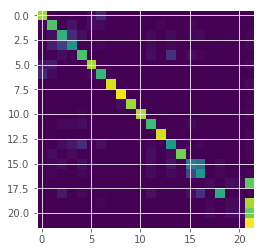

In [66]:
y_pred = clf.predict(X_test)
imshow(confusion_matrix(y_test, y_pred))

In [67]:
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.82      0.85      0.83       151
        14d       0.70      0.81      0.75       134
         1d       0.63      0.70      0.66       139
         2t       0.62      0.60      0.61       126
        30d       0.72      0.73      0.72       146
         7d       0.88      0.84      0.86       154
        ada       0.76      0.80      0.78       123
       afas       0.99      0.96      0.97       146
        exp       0.97      0.99      0.98       147
         ez       0.99      0.95      0.97       134
         ff       0.98      0.96      0.97       137
         mc       0.76      0.84      0.80       123
         mr       0.99      0.98      0.98       142
      month       0.66      0.62      0.63       130
        rfm       0.98      0.84      0.91       140
         rr       0.54      0.42      0.47       146
        sen       0.48      0.62      0.55       125
       spec       0.36      0.03      0.06   

### the model now is performing bettter as the precision and recall have increased

# 5. Fourier transform

In [68]:
# change value to floats to be able to change (-1) values to nans
mta = mta.astype(float)

# assign -1 values to nan
mta[mta == -1] = np.nan

In [69]:
# summing along axis 1 ridership types
mta_ = np.nansum(mta, axis=1)
print ("MTA array shape summed over all ride types:", mta_.shape)

MTA array shape summed over all ride types: (600, 194)


In [70]:
mta_.shape

(600, 194)

In [71]:
N = 3 * 52 
f = np.square((np.fft.rfft(mta_, n=N).real))
f.shape

(600, 79)

In [72]:
np.fft.rfftfreq(N, 1.0)

array([ 0.        ,  0.00641026,  0.01282051,  0.01923077,  0.02564103,
        0.03205128,  0.03846154,  0.04487179,  0.05128205,  0.05769231,
        0.06410256,  0.07051282,  0.07692308,  0.08333333,  0.08974359,
        0.09615385,  0.1025641 ,  0.10897436,  0.11538462,  0.12179487,
        0.12820513,  0.13461538,  0.14102564,  0.1474359 ,  0.15384615,
        0.16025641,  0.16666667,  0.17307692,  0.17948718,  0.18589744,
        0.19230769,  0.19871795,  0.20512821,  0.21153846,  0.21794872,
        0.22435897,  0.23076923,  0.23717949,  0.24358974,  0.25      ,
        0.25641026,  0.26282051,  0.26923077,  0.27564103,  0.28205128,
        0.28846154,  0.29487179,  0.30128205,  0.30769231,  0.31410256,
        0.32051282,  0.32692308,  0.33333333,  0.33974359,  0.34615385,
        0.3525641 ,  0.35897436,  0.36538462,  0.37179487,  0.37820513,
        0.38461538,  0.39102564,  0.3974359 ,  0.40384615,  0.41025641,
        0.41666667,  0.42307692,  0.42948718,  0.43589744,  0.44

Text(0.5,1,'Swipes per Station power spectrum')

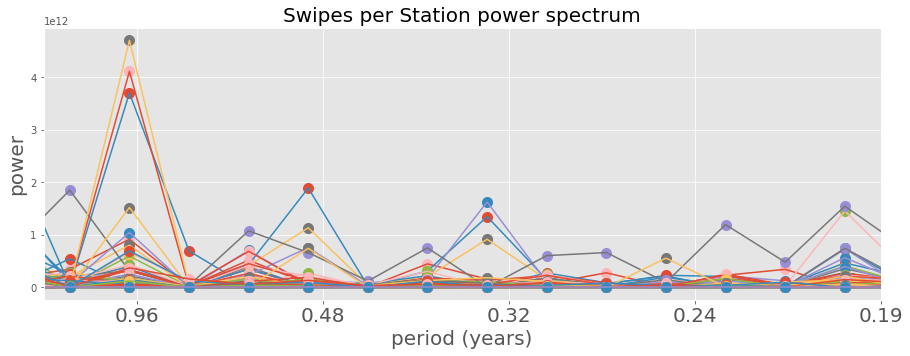

In [73]:
# plotting the fourier transform of all 600 time series
fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(111)

for i in range(len(mta_)):
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[i][1:]), 'o', ms=10)
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[i][1:]), '-')
    
#ax.set_xlim(0,1.0/15)
ax.set_xlim(1/100,1.0/10)

ax.set_xticklabels(["%.2f"%(1/52/tick) for tick in ax.get_xticks()], fontsize=20)
ax.set_ylabel("power", fontsize=20)
ax.set_xlabel("period (years)", fontsize=20)
ax.set_title("Swipes per Station power spectrum", fontsize=20)

**Figure 3** This is a plot of the fourier transform of the 600 stations. We removing the first entry of the FFT output array  because it is not physically interesting and it is always a very large number. By plotting the points [1:], i.e. the FFT omitting its first value, we can see what happens much better, since the high value at [0] will force the y range in the plot to be very large. We observe a peak in the plot at a period of almost one year. the next step is identifying the time series that have peaked.

In [74]:
x = np.argsort(-f[:,3])
x[:4]

array([194, 150,   0, 327])

Text(0.5,1,'Swipes per Station power spectrum')

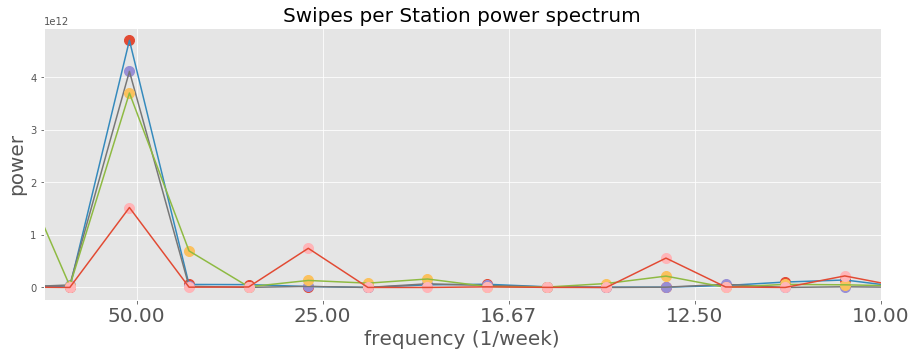

In [75]:
# plotting the highest peaks
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

for i in x[:4]:
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[i][1:]), 'o', ms=10)
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[i][1:]), '-')
    
#ax.set_xlim(0,1.0/15)
ax.set_xlim(1/100,1.0/10)

ax.set_xticklabels(["%.2f"%(1/tick) for tick in ax.get_xticks()], fontsize=20)
ax.set_ylabel("power", fontsize=20)
ax.set_xlabel("frequency (1/week)", fontsize=20)
ax.set_title("Swipes per Station power spectrum", fontsize=20)

Text(0,0.5,'Number of Swipes per Week')

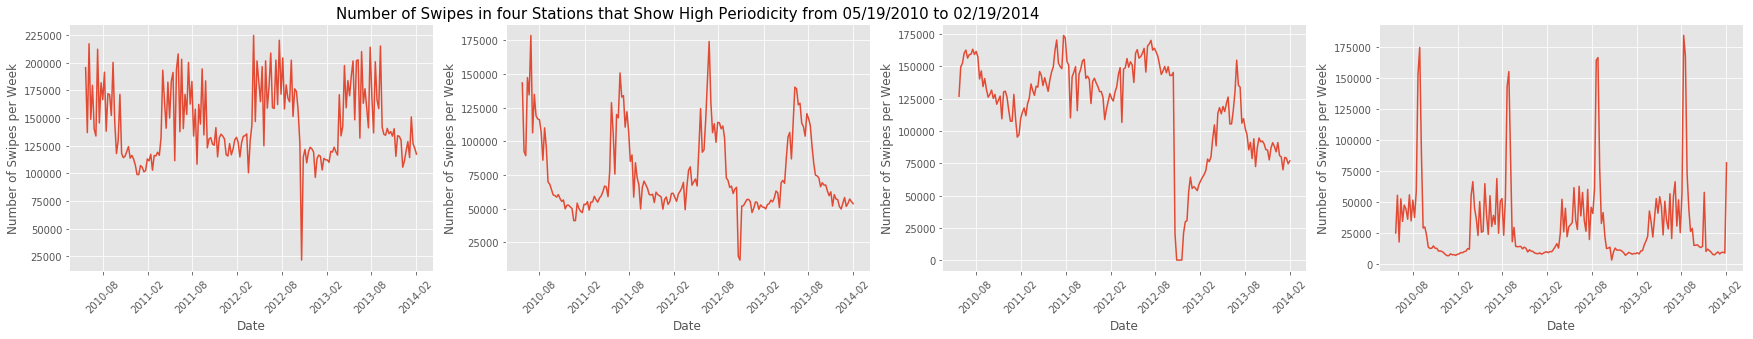

In [76]:
fig = plt.figure(figsize=(30,10))
fig.add_subplot(241)

date = pd.date_range(start='05/19/2010', periods=194, freq='W')

plt.plot(date, mta_[194])
plt.xlabel('Date', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('Number of Swipes per Week', fontsize=12)

fig.add_subplot(242)
plt.plot(date, mta_[150])
plt.xlabel('Date', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('Number of Swipes per Week', fontsize=12)
plt.title('Number of Swipes in four Stations that Show High Periodicity from 05/19/2010 to 02/19/2014', fontsize=15)

fig.add_subplot(243)
plt.plot(date, mta_[0])
plt.xlabel('Date', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('Number of Swipes per Week', fontsize=12)

fig.add_subplot(244)
plt.plot(date, mta_[327])
plt.xlabel('Date', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('Number of Swipes per Week', fontsize=12)

**Figure 5** plot of the time series that have shown high periodcity in the fourier transform. It looks like the peaks are around the end of the year starting from the end of the  summer season (August/September) in which toursits tend to visit the city which will raise the number of people using the sybway and show similar seasonality to what we are seeing here.